In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class SIRModel(Dataset):
    def __init__(self, S0, I0, R0, beta, gamma, days):
        """
        初始化 SIR 模型数据集
        :param S0: 初始易感者数量
        :param I0: 初始感染者数量
        :param R0: 初始康复者数量
        :param beta: 感染率
        :param gamma: 康复率
        :param days: 模拟的天数
        """
        self.S0, self.I0, self.R0 = S0, I0, R0
        self.beta, self.gamma = beta, gamma
        self.days = days
        self.data = self.simulate()

    def simulate(self):
        # 初始化
        S, I, R = self.S0, self.I0, self.R0
        sir_data = []
        for _ in range(self.days):
            sir_data.append([S, I, R])
            new_infected = self.beta * S * I / (S + I + R)
            new_recovered = self.gamma * I
            S = S - new_infected
            I = I + new_infected - new_recovered
            R = R + new_recovered
        return np.array(sir_data)

    def __len__(self):
        return self.days

    def __getitem__(self, idx):
        # 在 PyTorch 中，通常希望数据是张量格式，这里我们将数据转化为 torch.Tensor
        return torch.tensor(self.data[idx], dtype=torch.float)

# 使用示例
S0, I0, R0 = 999, 1, 0  # 初始状态
beta, gamma = 0.3, 0.1  # 感染率和康复率
days = 50  # 模拟50天的传播

sir_dataset = SIRModel(S0, I0, R0, beta, gamma, days)
for day, (S, I, R) in enumerate(sir_dataset):
    print(f"Day {day}: Susceptible={S.item()}, Infected={I.item()}, Recovered={R.item()}")

In [31]:
import torch
from torch.utils.data import Dataset
import numpy as np
from scipy.stats import multivariate_normal

class SIRModel(Dataset):
    def __init__(self, size_list, beta, gamma, steps, dt, interval, sigma, rou):
        """
        初始化 SIR 模型数据集
        :param size_list: 初始状态点的数量和分布（依据易感者比例划分条带）
        :param beta: 感染率
        :param gamma: 康复率
        :param steps: 运行的步数（结果包含起始点）
        :param dt: 步长
        :param interval: 采样间隔
        :param sigma: 噪音的标准差大小
        :param rou: 噪音的相关系数
        """
        self.size_list = size_list
        self.beta, self.gamma = beta, gamma
        self.sigma, self.rou = sigma, rou
        self.steps = steps
        self.dt = dt
        self.interval = interval
        self.init_total_number = np.sum(size_list)
        #self.data = self.simulate_multiseries(size_list)
        self.prior = multivariate_normal(mean=np.zeros(2), cov=np.array([[1, rou], [rou, 1]]))

    def perturb(self, S, I):
        '''
        加观测噪音的函数，输入宏观状态S、I，输出4维的微观态
        '''
        noise_S = self.prior.rvs(size=1) * self.sigma
        noise_I = self.prior.rvs(size=1) * self.sigma
        S_observed0 = np.expand_dims(S + noise_S[0], axis=0)
        S_observed1 = np.expand_dims(S + noise_S[1], axis=0)
        I_observed0 = np.expand_dims(I + noise_I[0], axis=0)
        I_observed1 = np.expand_dims(I + noise_I[1], axis=0)
        SI_observed = np.concatenate((S_observed0, I_observed0, S_observed1, I_observed1), 0)
        return SI_observed
    
    def simulate_oneserie(self, S, I):
        '''
        从某一个特定起始点出发的单个时间序列
        输入S，I：初始值（比例）
        '''
        sir_data = []
        for k in range(self.steps):
            if k % self.interval == 0:
                SI_observed = self.perturb(S, I)
                sir_data.append(SI_observed)
                
            new_infected = self.beta * S * I 
            new_recovered = self.gamma * I
            S = S - new_infected * self.dt
            I = I + (new_infected - new_recovered) * self.dt
        return np.array(sir_data)

    def simulate_multiseries(self):
        '''
        多个起始点的时间序列，生成数据集的主函数。在这里实现把数据集划分成多个条带。
        '''
        num_observed = int(self.steps / self.interval)
        sir_data_all = np.zeros([self.init_total_number, num_observed, 4])
        num_strip = len(self.size_list)
        frac = 1 / num_strip
        
        for strip in range(num_strip):
            sir_data_part = np.zeros([self.size_list[strip], num_observed, 4])
            boundary_left = strip * frac
            boundary_right = boundary_left + frac
            S_init = np.random.uniform(boundary_left, boundary_right, self.size_list[strip])
            I_init = []
            while len(I_init) < self.size_list[strip]:
                I = np.random.rand(1)[0]
                S = S_init[len(I_init)]
                if S + I <= 1:
                    sir_data_part[len(I_init),:,:] = self.simulate_oneserie(S, I)
                    I_init.append(I)
            size_list_cum = np.cumsum(self.size_list)
            size_list_cum = np.concatenate([[0], size_list_cum])
            sir_data_all[size_list_cum[strip]:size_list_cum[strip+1], :, :] = sir_data_part
            #[9000,7,4]
        sir_input, sir_output = self.reshape(sir_data_all = sir_data_all)
            
        return sir_input, sir_output

    def reshape(self, sir_data_all):
        '''
        把生成的多时间序列变成输入和输出。
        sir_data_all: [diff_init, steps, status] -> (sir_input:[diff_init, (steps-1), status], sir_output:[diff_init, (steps-1), status])
        -> ([diff_init * (steps-1), status], [diff_init * (steps-1), status])  (batch_size=)
        '''
        sir_input = sir_data_all[:, :-1, :].reshape(-1, 4)
        sir_output = sir_data_all[:, 1:, :].reshape(-1, 4)
        return sir_input, sir_output


    def __len__(self):
        return self.days

    def __getitem__(self, idx):
        # 在 PyTorch 中，通常希望数据是张量格式，这里我们将数据转化为 torch.Tensor
        return torch.tensor(self.data[idx], dtype=torch.float)

sir = SIRModel(size_list=[9000], beta=1, gamma=0.5, steps=7, dt=0.01, interval=1, sigma=0.03, rou=-0.5)
data = sir.simulate_multiseries()
data[0].shape, data[1].shape

((54000, 4), (54000, 4))

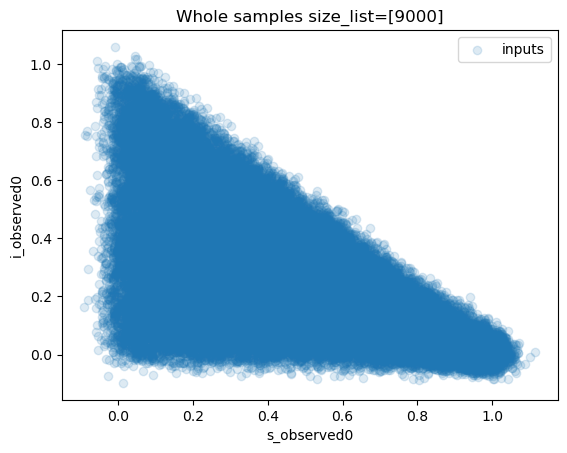

In [32]:
import matplotlib.pyplot as plt

inputs, outputs = data


# 绘制散点图
plt.scatter(inputs[:, 0], inputs[:, 1], alpha=0.15, label='inputs')
plt.legend()
# 添加标题和标签
plt.title('Whole samples size_list=[9000]')
plt.xlabel('s_observed0')
plt.ylabel('i_observed0')

# 显示图形
plt.show()

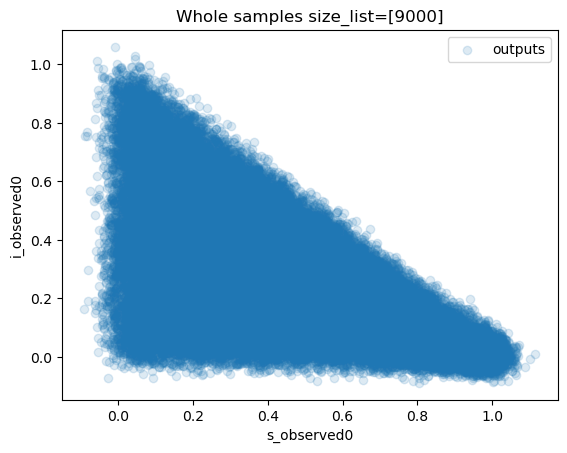

In [33]:
import matplotlib.pyplot as plt

# 绘制散点图
plt.scatter(outputs[:, 0], outputs[:, 1], alpha=0.15, label='outputs')
plt.legend()
# 添加标题和标签
plt.title('Whole samples size_list=[9000]')
plt.xlabel('s_observed0')
plt.ylabel('i_observed0')

# 显示图形
plt.show()

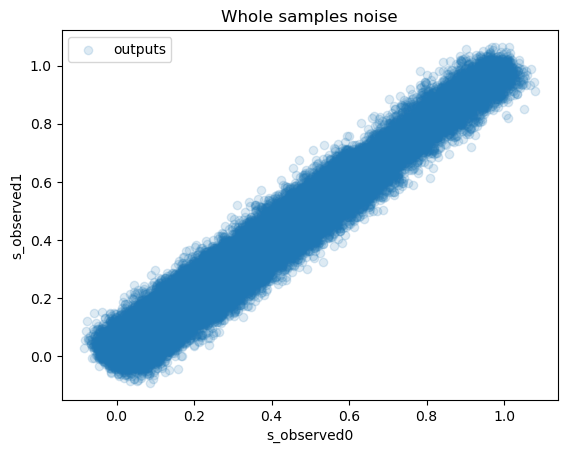

In [28]:
import matplotlib.pyplot as plt

# 绘制散点图
plt.scatter(outputs[:, 0], outputs[:, 2], alpha=0.15, label='outputs')
plt.legend()
# 添加标题和标签
plt.title('Whole samples noise')
plt.xlabel('s_observed0')
plt.ylabel('s_observed1')

# 显示图形
plt.show()

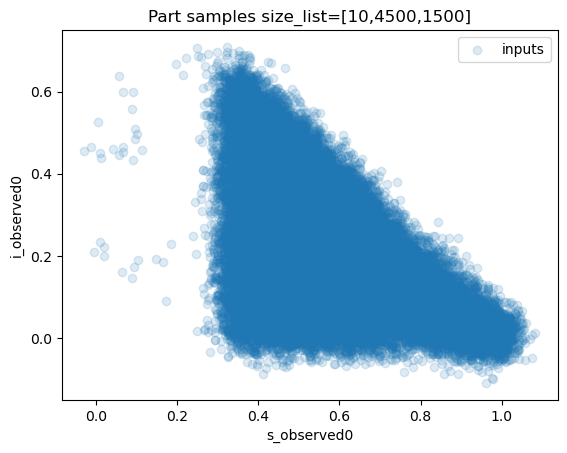

In [30]:
import matplotlib.pyplot as plt

inputs, outputs = data


# 绘制散点图
plt.scatter(inputs[:, 0], inputs[:, 1], alpha=0.15, label='inputs')
plt.legend()

# 添加标题和标签
plt.title('Part samples size_list=[10,4500,1500]')
plt.xlabel('s_observed0')
plt.ylabel('i_observed0')

# 显示图形
plt.show()